In [826]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preparing data for Time Series Analysis

In [827]:
df = pd.read_csv('./final_data.csv', parse_dates=['Date'], index_col='Date')

In [828]:
df = df[df['Cash Flow'] == 'Expense']

In [829]:
df.sort_index(inplace=True)

In [830]:
df.head()

,Note,Amount,Cash Flow,Category,Month,Day,Year
Date,,,,,,,
2015-01-01,share auto - hospital to brc station,10.0,Expense,Transport,1,1,2015
2015-01-01,bus - brc to Place H,30.0,Expense,Transport,1,1,2015
2015-01-01,share auto - Place H to Place T base,20.0,Expense,Transport,1,1,2015
2015-01-01,share jeep - Place T base to top,20.0,Expense,Transport,1,1,2015
2015-01-01,ropeway Place T to and fro,142.0,Expense,Transport,1,1,2015


In [831]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1830 entries, 2015-01-01 to 2018-12-09
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Note       1830 non-null   object 
 1   Amount     1830 non-null   float64
 2   Cash Flow  1830 non-null   object 
 3   Category   1830 non-null   object 
 4   Month      1830 non-null   int64  
 5   Day        1830 non-null   int64  
 6   Year       1830 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 114.4+ KB


In [832]:
weekly_spending = df['Amount'].resample('W').sum()

In [833]:
weekly_spending = weekly_spending.asfreq('W')

In [834]:
weekly_spending.shape

(206,)

<Axes: xlabel='Date'>

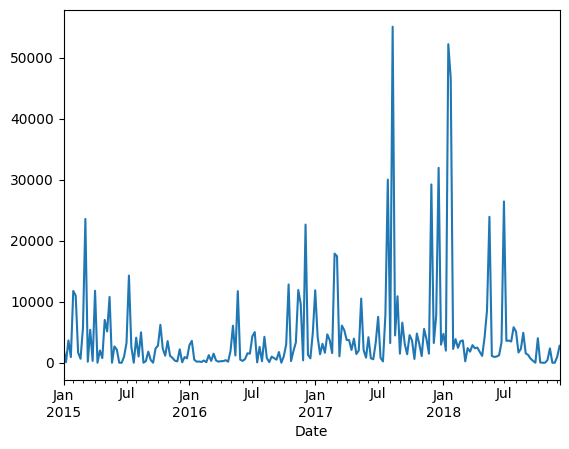

In [835]:
weekly_spending.plot()

In [836]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
sr = pd.Series(np.squeeze(pt.fit_transform(np.expand_dims(weekly_spending, 1))))
sr.index = weekly_spending.index
weekly_spending = sr


In [837]:
# Removing outliers

z_score = (weekly_spending - weekly_spending.mean()) /weekly_spending.std()
weekly_spending = weekly_spending[z_score < 2]

In [838]:
weekly_spending.shape

(199,)

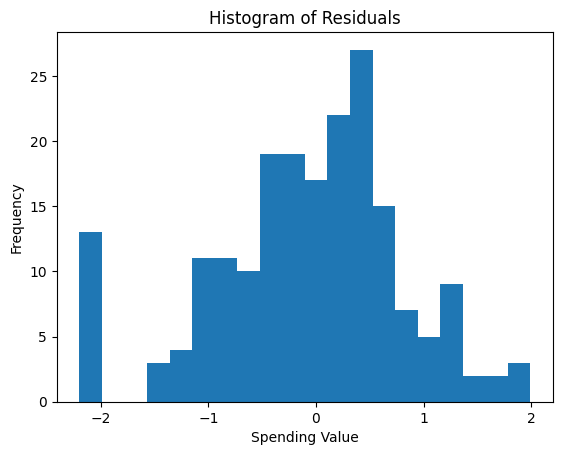

In [839]:
plt.hist(weekly_spending, bins=20)
plt.title("Histogram of Residuals")
plt.xlabel("Spending Value")
plt.ylabel("Frequency")
plt.show()


In [840]:
weekly_spending = weekly_spending.asfreq('W')

In [841]:
weekly_spending = weekly_spending.interpolate()

<Axes: xlabel='Date'>

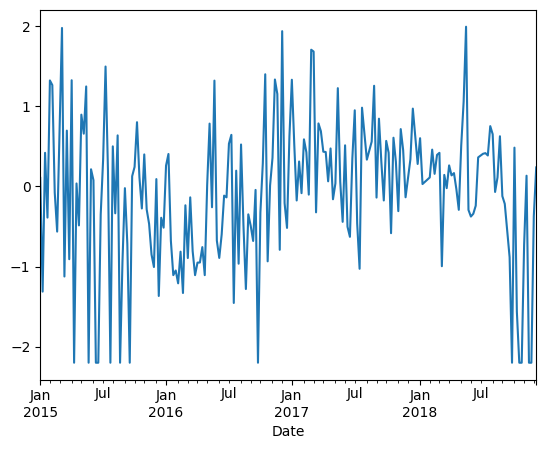

In [842]:
weekly_spending.plot()

# 2. Testing Stationarity

In [843]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(weekly_spending)
print('ADF stat: ', result[0])
print('P Values: ', result[1])

ADF stat:  -4.264262539032895
P Values:  0.0005119531459962807


Hence, the time series data is stationary

# 3. Finding parameters for SARIMA

Text(0, 0.5, 'Autocorrelation')

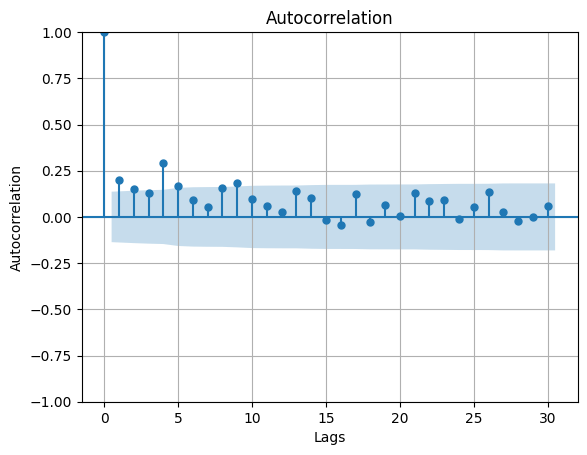

In [844]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(weekly_spending, lags=30)
plt.xlabel('Lags')
plt.grid(True)
plt.ylabel('Autocorrelation')

So, q = 4

Text(0, 0.5, 'Autocorrelation')

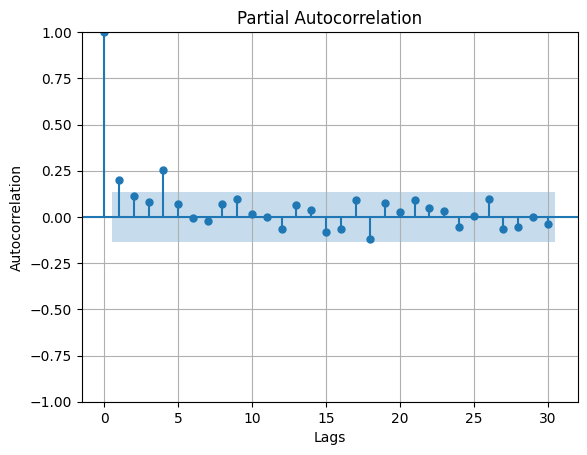

In [845]:
plot_pacf(weekly_spending, lags=30)
plt.xlabel('Lags')
plt.grid(True)
plt.ylabel('Autocorrelation')

So, p = 4

In [899]:
seasonal_diff = weekly_spending.diff(24)
seasonal_diff.dropna(inplace=True)

result = adfuller(seasonal_diff)
print('Pval: ', result[1])

Pval:  0.0025030901093126704


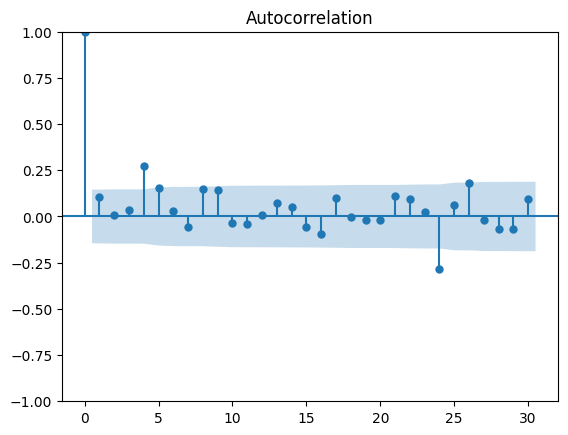

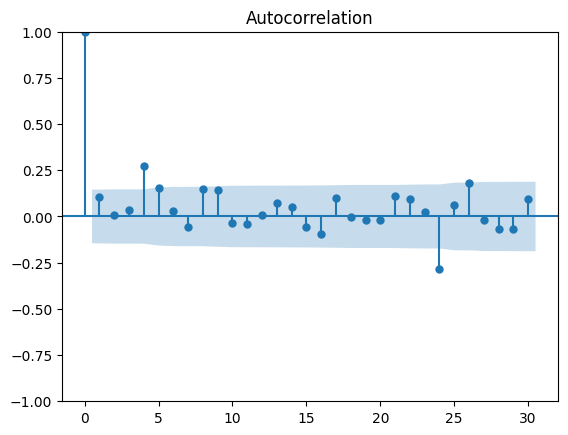

In [900]:
plot_acf(seasonal_diff, lags=30)

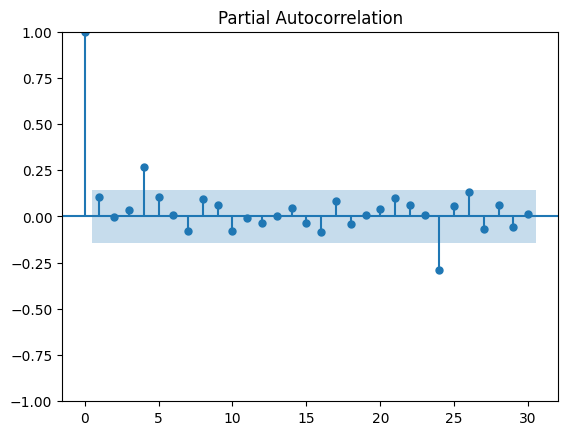

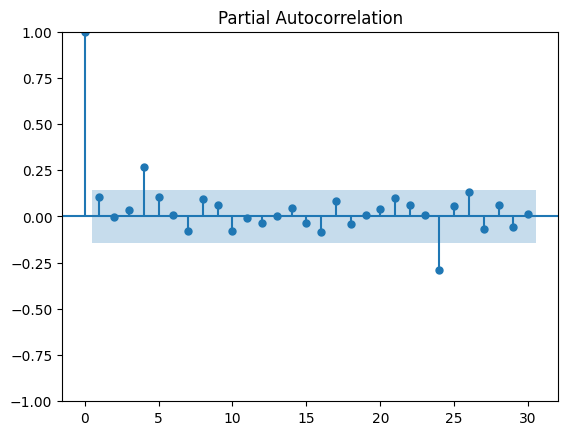

In [901]:
plot_pacf(seasonal_diff, lags=30)

So, P = 4,  Q = 4, m = 24

#### Now validating using auto arima

In [902]:
from pmdarima import auto_arima

model = auto_arima(weekly_spending,
                   seasonal=True,
                   m=24,
                   trace=True,
                   stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=525.704, Time=2.32 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=539.798, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=535.132, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=536.841, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=539.170, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[24] intercept   : AIC=525.472, Time=1.45 sec
 ARIMA(2,0,2)(0,0,0)[24] intercept   : AIC=525.916, Time=0.37 sec
 ARIMA(2,0,2)(0,0,2)[24] intercept   : AIC=524.520, Time=4.12 sec
 ARIMA(2,0,2)(1,0,2)[24] intercept   : AIC=526.518, Time=4.84 sec
 ARIMA(1,0,2)(0,0,2)[24] intercept   : AIC=522.655, Time=2.21 sec
 ARIMA(1,0,2)(0,0,1)[24] intercept   : AIC=523.642, Time=0.55 sec
 ARIMA(1,0,2)(1,0,2)[24] intercept   : AIC=524.643, Time=4.57 sec
 ARIMA(1,0,2)(1,0,1)[24] intercept   : AIC=523.900, Time=1.51 sec
 ARIMA(0,0,2)(0,0,2)[24] intercept   : AIC=534.777, Time=0.97 sec
 ARIMA(1,0,1)(0,0,2)[24] intercep

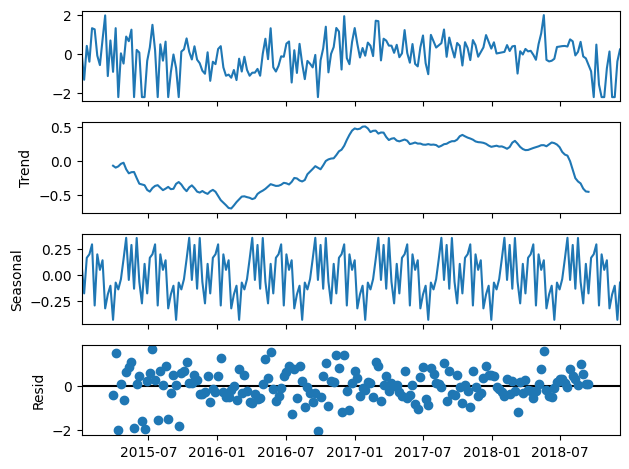

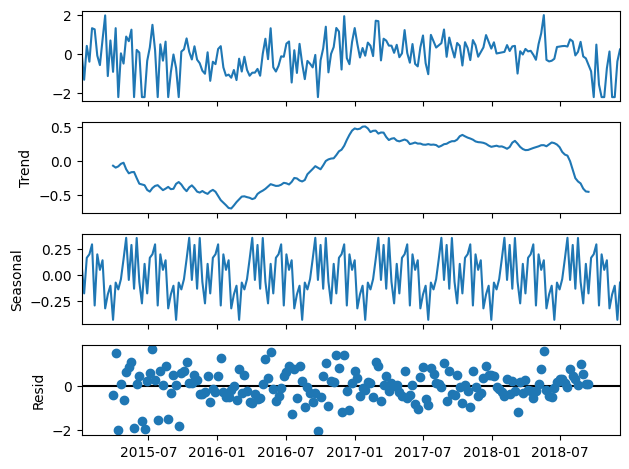

In [903]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assume monthly_spending_cleaned is your cleaned monthly time series

decomposition = seasonal_decompose(weekly_spending, model='additive', period=24)

decomposition.plot()


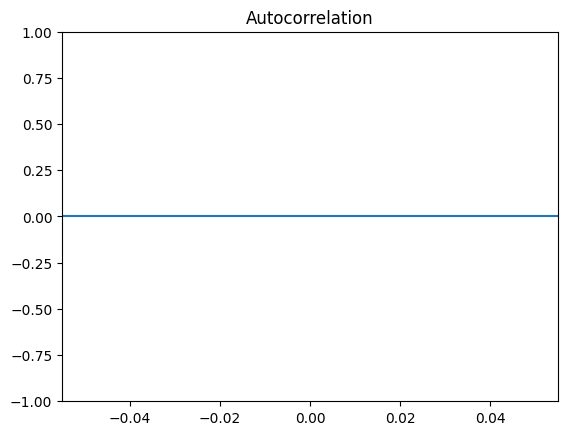

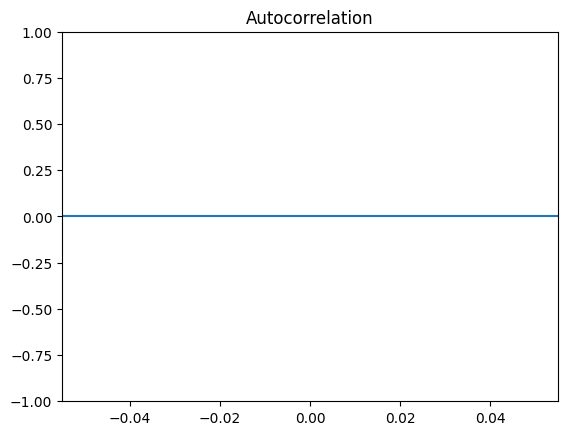

In [904]:
# Checking for the trend seasonality in residue
resid = decomposition.resid
plot_acf(resid, lags=30)

In [905]:
print("Mean of residuals:", resid.mean())


Mean of residuals: 0.01329442765750505


In [906]:
resid.dropna(inplace=True)

In [909]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(resid, lags=range(29))
print(lb_test)


      lb_stat  lb_pvalue
0   35.621601        NaN
1    0.061749   0.803753
2    2.584749   0.274618
3    3.858626   0.277140
4    4.311473   0.365491
5    4.311574   0.505483
6    5.535505   0.477176
7    9.362532   0.227665
8    9.872150   0.274114
9   11.416833   0.248215
10  12.069908   0.280405
11  15.089052   0.178456
12  15.089053   0.236602
13  15.616570   0.270456
14  16.619257   0.277036
15  17.926643   0.266542
16  20.279728   0.207885
17  22.292378   0.173735
18  23.934221   0.157195
19  24.035841   0.194781
20  24.178678   0.234674
21  26.741481   0.179575
22  26.764527   0.220307
23  26.781538   0.265377
24  30.040056   0.183428
25  30.176471   0.217749
26  34.115300   0.132146
27  34.354028   0.155996
28  35.621601   0.152489


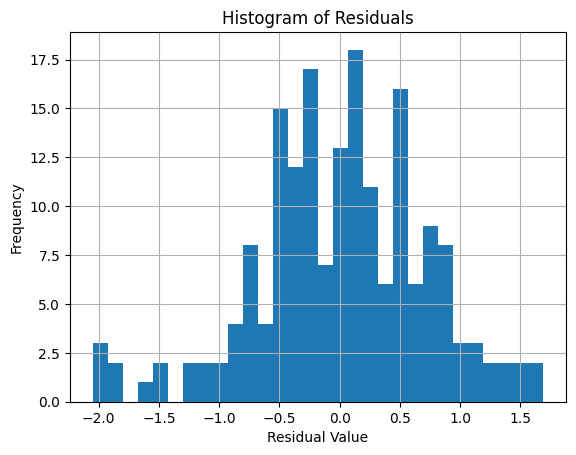

In [926]:
resid.hist(bins=30)
plt.title("Histogram of Residuals")
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.show()


In [924]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(weekly_spending,
                order=(4,0,4),
                seasonal_order=(4,1,4,24),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  206
Model:             SARIMAX(4, 0, 4)x(4, 1, 4, 24)   Log Likelihood                 -83.510
Date:                            Sun, 01 Jun 2025   AIC                            201.020
Time:                                    20:34:48   BIC                            241.726
Sample:                                01-04-2015   HQIC                           217.352
                                     - 12-09-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5813      2.104      0.276      0.782      -3.542       4.705
ar.L2          0.3983      2.085   

In [927]:
residuals = results.resid

<Axes: xlabel='Date'>

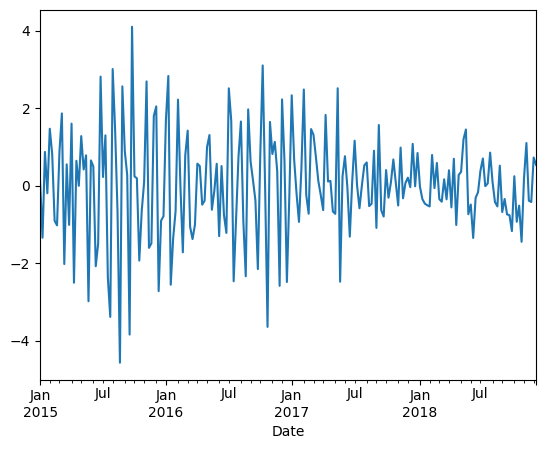

In [928]:
residuals.plot()

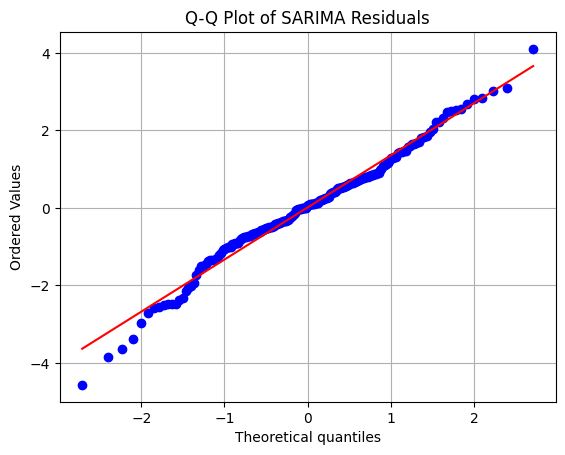

In [929]:
import scipy.stats as stats

stats.probplot(residuals.dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of SARIMA Residuals')
plt.grid()
plt.show()

Hence, the residue have normal distribution

# 4. Performing Forecast

In [930]:
n_steps = 10  # forecast horizon
forecast = results.get_forecast(steps=n_steps)

In [931]:
conf_int = forecast.conf_int()

In [932]:
forecast_original = pd.Series(np.squeeze(pt.inverse_transform(np.expand_dims(forecast.predicted_mean, axis=1))))
weekly_spending_original = pd.Series(np.squeeze(pt.inverse_transform(np.expand_dims(weekly_spending, axis=1))))

forecast_original.index = forecast.predicted_mean.index
weekly_spending_original.index = weekly_spending.index

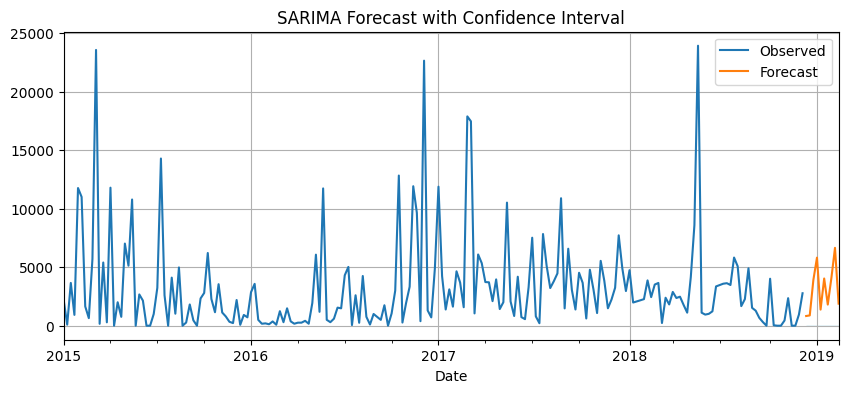

In [933]:
import matplotlib.pyplot as plt

weekly_spending_original.plot(label='Observed', figsize=(10,4))
forecast_original.plot(label='Forecast')
plt.fill_between(forecast_original.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='lightblue', alpha=0.3)

plt.title('SARIMA Forecast with Confidence Interval')
plt.legend()
plt.grid()
plt.show()


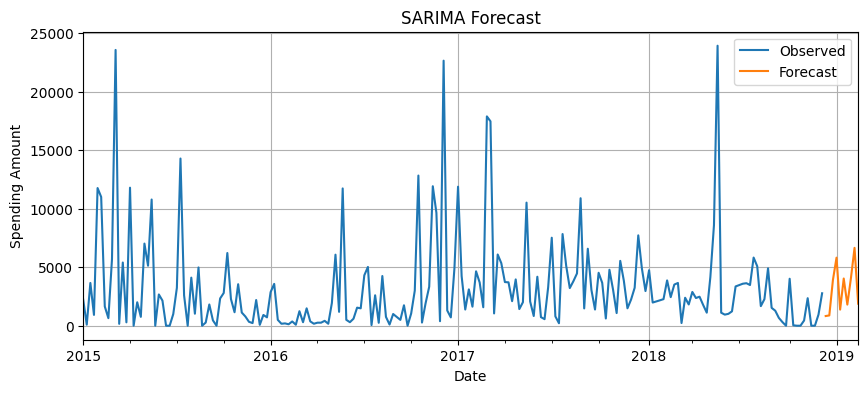

In [934]:
# Plot original series
weekly_spending_original.plot(label='Observed', figsize=(10, 4))

# Plot forecasted mean
forecast_original.plot(label='Forecast')



plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Spending Amount')
plt.legend()
plt.grid()
plt.show()


# 6. Performing Cross-Validation

In [935]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [936]:
rmse_scores = []
tscv = TimeSeriesSplit(n_splits=10)

for train_index, test_index in tscv.split(weekly_spending):
    train, test = weekly_spending.iloc[train_index], weekly_spending.iloc[test_index]

    # Fit SARIMA on training
    model = SARIMAX(train,
                    order=(4,0,4),
                    seasonal_order=(4,1,4,24),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    
    results = model.fit(disp=False)
    
    # Forecast the length of the test set
    forecast = results.forecast(steps=len(test))
    
    # Calculate RMSE for this fold
    rmse = np.sqrt(mean_squared_error(test, forecast))
    rmse_scores.append(rmse)

    print(f"Fold RMSE: {rmse:.2f}")


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fold RMSE: 1.78


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fold RMSE: 33.74


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fold RMSE: 1.10


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fold RMSE: 2.61


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fold RMSE: 2.05


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fold RMSE: 1.90


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold RMSE: 1.35


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Fold RMSE: 0.51


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold RMSE: 0.71


c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\JARVIS\anaconda3\envs\env_torch\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fold RMSE: 1.53


In [937]:
forecast_original = pd.Series(np.squeeze(pt.inverse_transform(np.expand_dims(forecast, axis=1))))
weekly_spending_original = pd.Series(np.squeeze(pt.inverse_transform(np.expand_dims(test, axis=1))))

forecast_original.index = forecast.index
weekly_spending_original.index = test.index

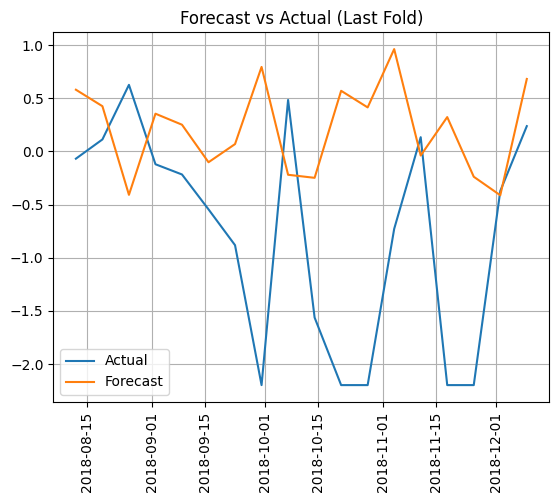

In [939]:
import matplotlib.pyplot as plt

plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.title('Forecast vs Actual (Last Fold)')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()


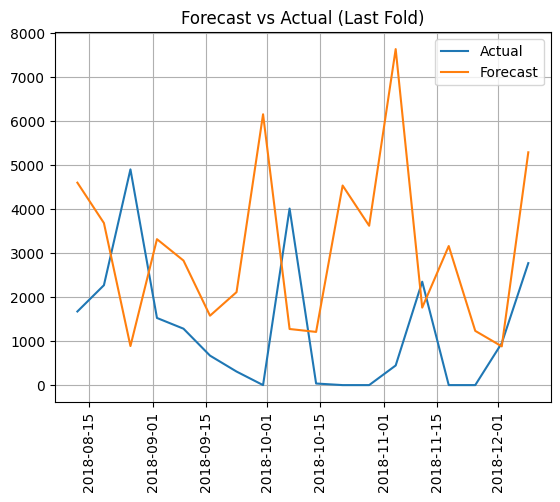

In [940]:
import matplotlib.pyplot as plt

plt.plot(test.index, weekly_spending_original, label='Actual')
plt.plot(test.index, forecast_original, label='Forecast')
plt.title('Forecast vs Actual (Last Fold)')
plt.legend()
plt.grid()
plt.xticks(rotation=90)
plt.show()
